# Note

The following tutorial is for the upcoming py50 v1.0.0 update. Interested parties can install the current code directly from the git repository, but there may (will most definitely!) be issues that will need to be ironed out before official release. This tutorial is a way for me to keep track of the functions I have implemented and to show off what I have planned.  

# Statistics Quickstart

**NOTE** 
This notebook is not meant to teach statistics, but only demo how to run the py50 functions. There are plenty of resources available online. I particularly found introductory [tutorials by DATAtab](https://datatab.net/tutorial/get-started) helpful. 

The following page will detail how to use the statistic calculations and the corresponding plots in py50. Essentially, py50 wraps three main python modules into a single package.  

1) Many of the functions are used similarly, with statistics using the 'get_x()' format, where x is the name. Statistic functions are wrappers from the [Pingouin](https://pingouin-stats.org/build/html/index.html) tool. If there are issues with the calculations using py50, the Pingouin may be a be a workaround.  

2) py50 wraps [Statannotation](https://github.com/trevismd/statannotations), which automatically adds statistical annotations to seaborn plots. The Pingouin statistics is also used to perform calculations. As such, users cna use Plots directly and show the output DataFrame for analysis/checking if needed.  

3) I also wrapped another tool that I like using - [scikit-posthocs](https://scikit-posthocs.readthedocs.io/en/latest/). This will plot a heatmap based on matplotlib/seaborn and highlight p-values between groups. I do not use calculations from scikit-posthocs, only the plotting options. The calculations come from the Pingouin package. Its usage in py50 requires a final calculated table, the py50.stats functions, before the final figure can be made. 

In [1]:
from py50.stats import Stats, Plots
import pingouin as pg
from matplotlib import pyplot as plt

# Initialize Stats() and Plots()
stats = Stats()
plot = Plots()

In [2]:
# Load an example dataset comparing pain threshold as a function of hair color
df = pg.read_dataset('anova')
print('List of Group names in Dataset:', df['Hair color'].unique())
working_df = df
working_df.head()

List of Group names in Dataset: ['Light Blond' 'Dark Blond' 'Light Brunette' 'Dark Brunette']


,Subject,Hair color,Pain threshold
0,1,Light Blond,62
1,2,Light Blond,60
2,3,Light Blond,71
3,4,Light Blond,55
4,5,Light Blond,48


## Data Distribution
The data distribution is important to determine patterns that may show up in the dataset. For example, it can also tell you how often a value may occur, the shape of the data, variability of a value, etc. 

py50 includes two tests that can help analyze the dataset. 
- Normality. This will test if the dataset follows normal distribution - i.e. a bell-shape curve.
- Homoscedasticity. This will test for the "spread" or consistency of the dataset along a regression model. 

In [3]:
# Test for normality
stats.get_normality(working_df).round(3)

,W,pval,normal
Subject,0.961,0.59,True
Pain threshold,0.971,0.80,True


In [4]:
stats.get_homoscedasticity(working_df, value_col='Pain threshold', group_col='Hair color').round(3)

,W,pval,equal_var
levene,0.393,0.76,True


## Visualize Data Distribution
Oftentimes it may be quicker and easier to visualize the distribution of the dataset. py50 includes a Histogram Plot and QQ Plot to visualize normality and homoscedasticity, respectively. The plots can be drawn individually, or if called as specific axes, can be combined into a single plot. Here I will draw them together in a grid. 

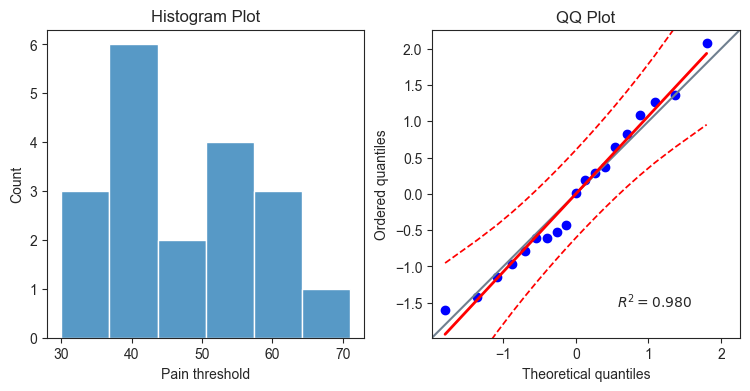

In [5]:
# create subplot grid
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
plot.distribution(working_df, val_col='Pain threshold', type='histplot', ax=ax1)
plot.distribution(working_df, val_col='Pain threshold', type='qqplot', ax=ax2)

# Adding titles to subplots
ax1.set_title('Histogram Plot')
ax2.set_title('QQ Plot')

plt.show()

## Perform One-Way ANOVA
Several tests, parametric and non-parametric, are available in py50. They use the "get_x" format. Here, the One-Way ANOVA script will be demoed. The final table will be a Pandas.DataFrame object. 

In [6]:
# Calculate ANOVA
anova = stats.get_anova(working_df, value_col='Pain threshold', group_col='Hair color')
anova

,Source,ddof1,ddof2,F,p-unc,np2,significance
0,Hair color,3,15,6.791407,0.004114,0.575962,**


ANOVA is a type of omnibus test and determines if a set of groups are statistically different. It does not tell you which group is different. For that, a post-hoc test is needed to perform pairwise comparisons between groups. This will signify which group is statistically significant. 

## Post-Hoc Tests
py50 comes with several post-hoc tests. Again, this can be called using the same 'get_x' phrase. As the above ANOVA test show significance between the Hair color group, a Tukey test will be performed. 

In [7]:
tukey = stats.get_tukey(working_df, value_col='Pain threshold', group_col='Hair color')
tukey

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,significance
0,Dark Blond,Dark Brunette,51.2,37.4,13.8,5.168623,2.669957,0.074068,1.413596,n.s.
1,Dark Blond,Light Blond,51.2,59.2,-8.0,5.168623,-1.547801,0.435577,-0.810661,n.s.
2,Dark Blond,Light Brunette,51.2,42.5,8.7,5.482153,1.586968,0.414728,0.982361,n.s.
3,Dark Brunette,Light Blond,37.4,59.2,-21.8,5.168623,-4.217758,0.003708,-2.336811,**
4,Dark Brunette,Light Brunette,37.4,42.5,-5.1,5.482153,-0.930291,0.789321,-0.626769,n.s.
5,Light Blond,Light Brunette,59.2,42.5,16.7,5.482153,3.046249,0.036647,2.015280,*


The calculated results show that only two groups ((Light Blond-Dark Brunette) and (Light Blond-Light Brunette)) with statistical significance.

The output table is the same format as the Pingouin,  but with the addition of a "significance" column. This denotes the typical asterisks associated with pvalues. The inclusion of this column is for quick visualization of results.  

## Plot results
py50 has wrapped functions from the [Statannotation](https://github.com/trevismd/statannotations) package, allowing annotations to be draw on a corresponding seaborn plot. This will allow statistical significance calculated from py50.Stats() module to be annotated on said figure. Sample plotting examples can be seen below. 

### General plotting
Several plotting options are available. They use the same parameters. Thus, only the name of the plot needs to be changed (for example plot.box_plot() vs. plot.bar_plot()). I personally prefer options and love to play with configurations. To that end, there are a lot of options available for tweaking the plot to your liking. First we will start with a general plot and see how it works before adding modifications.  

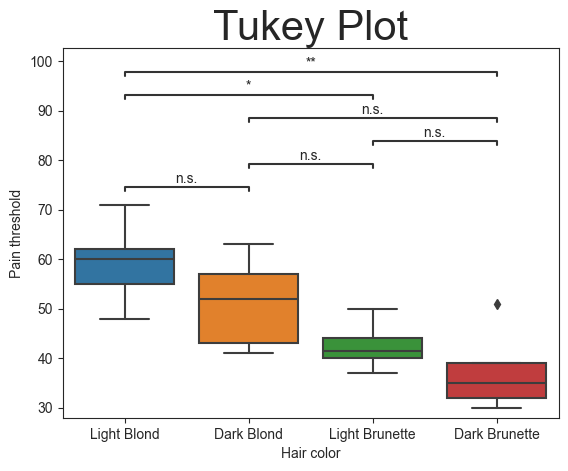

In [8]:
# General plotting
plot.box_plot(working_df, test='tukey', value_col='Pain threshold', group_col='Hair color', title='Tukey Plot', title_fontsize=30)

# to save fig
# plt.savefig('tukey_box_plot.png', bbox_inches='tight', dpi=300 )

The plot function is essentially another wrapper for the py50.Stats() module, but with the default final output being the plot. All plot functions also accept **kwargs associated for [Statannotations](https://statannotations.readthedocs.io/en/latest/index.html) or [Seaborn](https://seaborn.pydata.org/api.html). Their usage can be found on their sites accordingly. 

The figure can be saved by calling plt.savefig(). The example above shows a common method. 

### Plot modifications
That looks great! But the plot looks a little busy with all of the no significance (n.s.) indicators plotted. What if these were removed and only important/relevant information was annotated to the plot?

Good news! That can be achieved by including the 'pairs' parameter. This will take a list of the groups (from columns A and B) and will filter the results accordingly. The pairs can be in any order, as long as the combinations can be found on the resulting DataFrame and in the ['A'] and ['B'] columns. 

There is also a way to return the calculated DataFrame using the 'return_df' parameter. This is a way to check the calculated results and if they match with the pvalues calculated from the py50.Stats() module. If there are discrepancies, they can be changed manually by using the 'pvalue_order' parameter, which takes a list of string values. The two lits - pairs and pvalue_order - **must match** in length. The returned DataFrame will only contain rows matching with the pairs list. 

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,significance
0,Dark Brunette,Light Blond,37.4,59.2,-21.8,5.168623,-4.217758,0.003708,-2.336811,**
1,Light Blond,Light Brunette,59.2,42.5,16.7,5.482153,3.046249,0.036647,2.015280,*


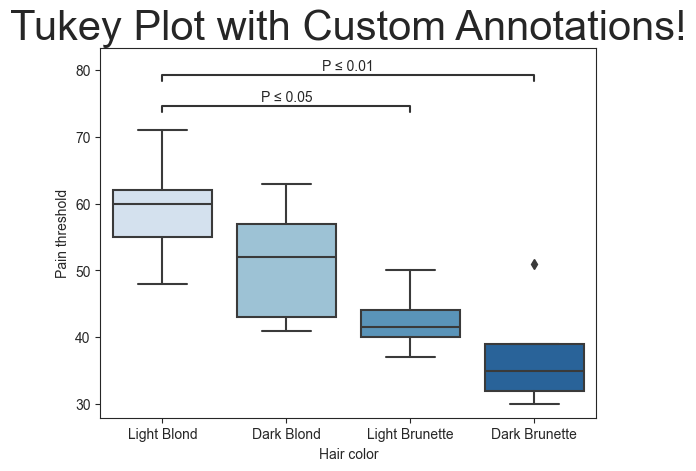

In [9]:
# Modify color and title size

pairs=[('Light Blond', 'Dark Brunette'), ('Light Blond', 'Light Brunette')]

# This is optional and will overwrite the significance asterisks associated with the pairs. 
pvalue_order=['P ≤ 0.01', 'P ≤ 0.05']

plot.box_plot(working_df, test='tukey', value_col='Pain threshold', group_col='Hair color', title='Tukey Plot with Custom Annotations!', title_fontsize=30, palette='Blues', pairs=pairs, return_df=True, pvalue_order=pvalue_order)

The color of the plot can also be modified using the palette parameter. As seen above, the palette can be divergent color scheme, such as "Blues", or distinct colors can be used. Input for distinct colors must be in a list.

The orientation of the plot can also be rotated from vertical to horizontal using the 'orient' parameter. 

The groups can also be reordered using the 'group_order' parameter. Let's place the groups in alphabetical order. 

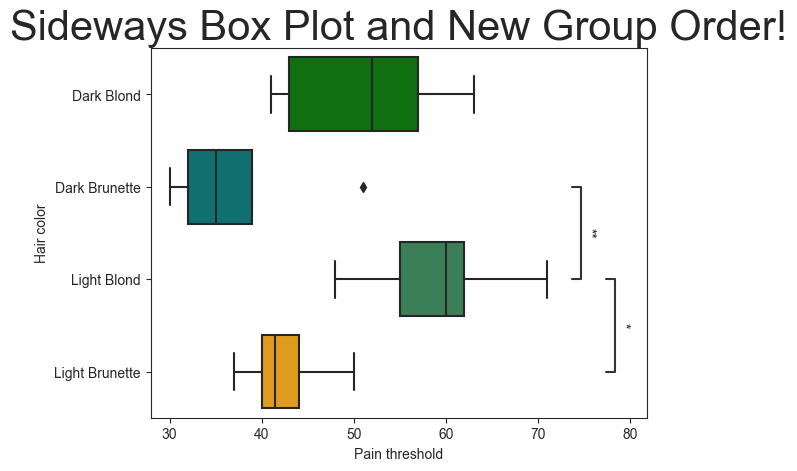

In [10]:
# Specify color and rotate
group_order = ['Dark Blond', 'Dark Brunette', 'Light Blond', 'Light Brunette']

palette = ['green', 'teal', 'seagreen', 'orange']
plot.box_plot(working_df, test='tukey', value_col='Pain threshold', group_col='Hair color', pairs=pairs, title='Sideways Box Plot and New Group Order!', title_fontsize=30, palette=palette, group_order=group_order, orient='h')

### Bar Plot
py50 contains functions for additional plot types. Again, they will accept the same parameters as the box_plot, as well as **kwargs associated with their respective Seaborn counterparts.

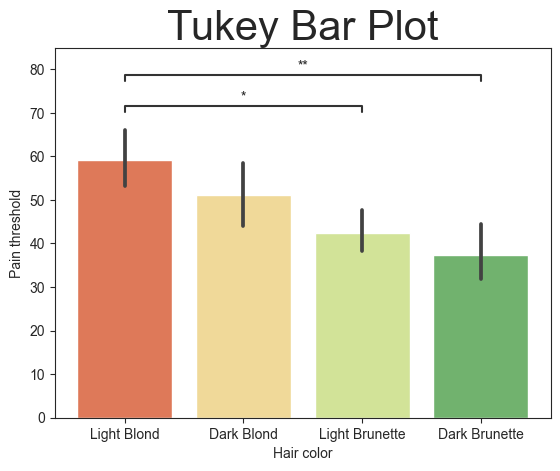

In [11]:
plot.bar_plot(working_df, test='tukey', value_col='Pain threshold', group_col='Hair color', title='Tukey Bar Plot', title_fontsize=30, palette='RdYlGn', pairs=pairs)

### Violin Plot
There are times when the annotations may be drawn on top of the figure. During testing, I found this occurs regularly with the violin or swarm plot. A workaround is to use the 'loc' parameter. This will place the annotations outside of the plot. The downside is that this will interfere with the title of the plot. In otherwords, if this paramter is used, it is best to remove the plot title. 

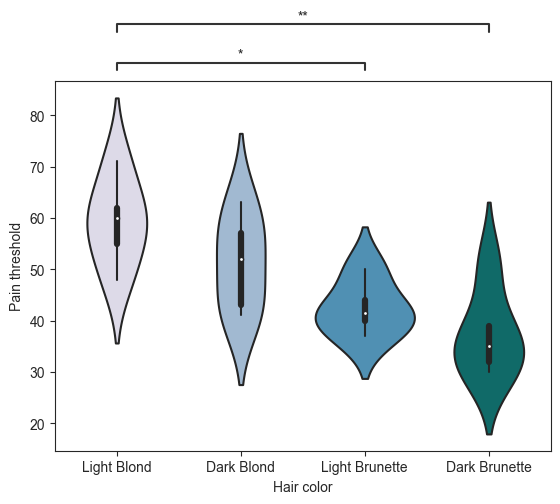

In [12]:
plot.violin_plot(working_df, test='tukey', value_col='Pain threshold', group_col='Hair color', palette='PuBuGn', pairs=pairs, loc='outside')

### Swarm Plot
There is also a swarm plot available. Again, it takes all the same parameters as above and with its respective Seaborn **kwargs. 

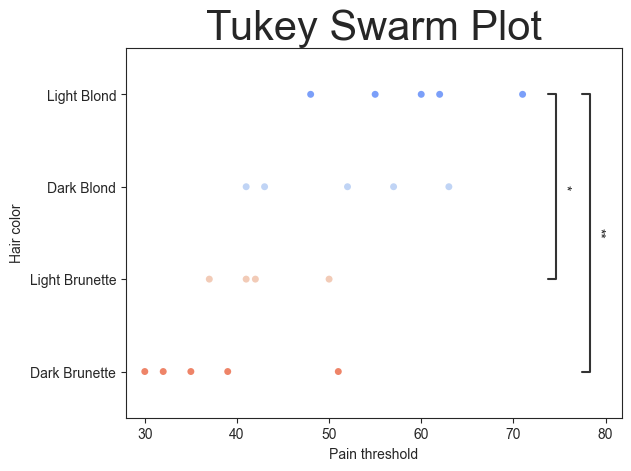

In [13]:
plot.swarmplot(working_df, test='tukey', value_col='Pain threshold', group_col='Hair color', title='Tukey Swarm Plot', title_fontsize=30, palette='coolwarm', pairs=pairs, orient='h')

### scikit-posthocs
Finally, a heatmap of pvalues can be generated. This script is a wrapper for the [scikit-posthoc](https://scikit-posthocs.readthedocs.io/en/latest/) tool. This is a good alternative to show a "clean" plot without annotations and have the pvalues represented on the side. It also offers a quick way to visualize the relationship between the groups. 

In order to create the pvalue heatmap, a matrix of the pvalues must be created. This is done using the 'get_p_matrix' from the Stats() module, as seen below. The output will be a DataFrame. 

In [14]:
# Replace all string values with a new value
matrix_df = stats.get_p_matrix(tukey, test='tukey', group_col1='A', group_col2='B')
matrix_df

,Dark Blond,Dark Brunette,Light Blond,Light Brunette
Dark Blond,1.000000,0.074068,0.435577,0.414728
Dark Brunette,0.074068,1.000000,0.003708,0.789321
Light Blond,0.435577,0.003708,1.000000,0.036647
Light Brunette,0.414728,0.789321,0.036647,1.000000


Once the pvalues are created in a matrix, the resulting DataFrame can be "fed" into the 'p_matrix' function in the Plots() module. There are many paramters for modifications available as the **kwargs, which can be found on the [scikist-posthocs documentation page](https://scikit-posthocs.readthedocs.io/en/latest/).

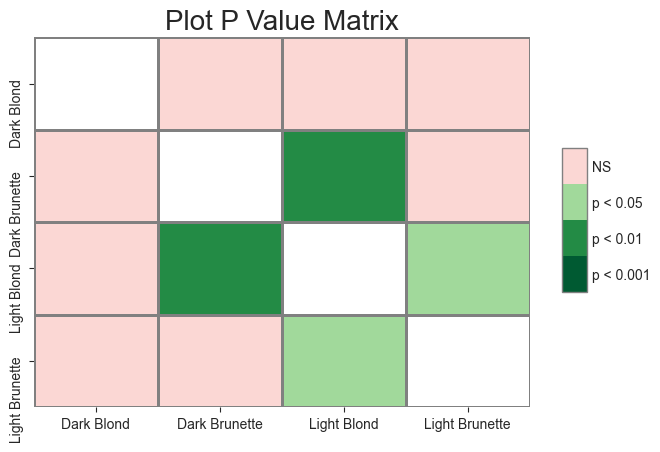

In [15]:
matrix_plot = plot.p_matrix(matrix_df, title='Plot P Value Matrix', title_fontsize=20, linewidth=1, linecolor='0.5')